
# MNIST Digit Classification and FGSM Attack

The following code will guide you through training a simple Multi-Layer Perceptron (MLP) model using Keras on the MNIST dataset. We will then implement the Fast Gradient Sign Method (FGSM) attack to generate adversarial examples and observe how they affect model performance.

## About MNIST Dataset
MNIST (Modified National Institute of Standards and Technology) is a dataset of 70,000 grayscale images of handwritten digits (0-9), each of size 28x28 pixels. The dataset is commonly used for training and testing machine learning models for digit recognition. It consists of:
- 60,000 training images
- 10,000 test images
- Labels corresponding to digits from 0 to 9


## Step 1: Importing Required Libraries

In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


## Step 2: Loading and Preprocessing the MNIST Dataset

In [2]:

# Load the MNIST dataset from Keras datasets
# This returns two tuples:
# - (x_train, y_train): Training images and their corresponding labels
# - (x_test, y_test): Testing images and their corresponding labels
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize the pixel values to the range [0,1] by dividing by 255
# This helps in faster and more stable training of the neural network
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape the images from 28x28 (2D) to a single 784-dimensional vector (1D)
# -1 automatically infers the batch size, keeping all images
# This transformation is necessary for feeding into a fully connected neural network
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Convert the labels from integer format (0-9) to one-hot encoded format
# Example: Label "3" → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
# This is required for categorical classification in neural networks
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)



## Step 3: Building the MLP Model

In [3]:

# Defining a Multi-Layer Perceptron (MLP) model for MNIST digit classification.
# We will use Keras' Sequential API to stack layers in a simple feedforward manner.

# The model consists of three layers:
# 1. **First Hidden Layer (512 neurons, ReLU activation)**:
#    - The input layer expects images of size 28x28, which are flattened into a 784-dimensional vector.
#    - This layer has 512 neurons to learn complex features from the digit images.
#    - The activation function used is **ReLU (Rectified Linear Unit)**, which helps introduce non-linearity and prevents the vanishing gradient problem.

# 2. **Second Hidden Layer (256 neurons, ReLU activation)**:
#    - A fully connected layer with 256 neurons.
#    - Also uses **ReLU activation** to maintain non-linearity.

# 3. **Output Layer (10 neurons, Softmax activation)**:
#    - The final layer has **10 neurons**, corresponding to the 10 digit classes (0-9).
#    - The **Softmax activation function** is used to output probability distributions over the 10 classes.

model = keras.Sequential([
    keras.Input(shape=(28*28,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])


## Step 4: Compiling and Training the Model

In [4]:
# Compiling the model:
# - Optimizer: 'adam' (adaptive learning rate for efficient training)
# - Loss: 'categorical_crossentropy' (suitable for multi-class classification)
# - Metric: 'accuracy' (measures correct predictions)

# Training the model:
# - Epochs: 10 (number of times the model sees the dataset)
# - Batch size: 128 (updates weights after every 128 samples)
# - Validation data: (x_test, y_test) (evaluates model performance on unseen data)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8789 - loss: 0.4197 - val_accuracy: 0.9649 - val_loss: 0.1110
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9741 - loss: 0.0856 - val_accuracy: 0.9731 - val_loss: 0.0822
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9834 - loss: 0.0551 - val_accuracy: 0.9791 - val_loss: 0.0681
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9873 - loss: 0.0382 - val_accuracy: 0.9744 - val_loss: 0.0810
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9919 - loss: 0.0258 - val_accuracy: 0.9776 - val_loss: 0.0759
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9945 - loss: 0.0185 - val_accuracy: 0.9797 - val_loss: 0.0713
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9936 - loss: 0.0195 - val_accuracy: 0.9787 - val_loss: 0.0804
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9957 - loss: 0.0136 - val_accur

## Step 5: Evaluating Model Performance

In [5]:
loss, accuracy = model.evaluate(x_test, y_test) # Evaluate the model on the test data

print(f"Test Accuracy: {accuracy:.4f}")  # Print the accuracy value with 4 decimal places



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9808 - loss: 0.0812
Test Accuracy: 0.9831


## Step 6: Implementing the FGSM Attack
We will use Fast Gradient Sign Method (FGSM) to create adversarial examples.


In [6]:
# The function fgsm_attack generates adversarial examples using the Fast Gradient Sign Method (FGSM).
# The FGSM method perturbs the input image in the direction of the gradient of the loss with respect to the image,
# scaled by a small value called epsilon. This creates an adversarial example that can deceive the model.

# Parameters:
# - image: The original input image that we want to perturb.
# - epsilon: A small scalar that controls the magnitude of the perturbation. A larger epsilon means a stronger perturbation.
# - gradient: The gradient of the loss with respect to the image. This is typically computed during backpropagation.

# The function performs the following:
# 1. Calculates the perturbation using the sign of the gradient, scaled by epsilon.
# 2. Adds this perturbation to the original image to generate the adversarial image.
# 3. Clips the resulting image to ensure the pixel values stay within the valid range [0, 1].
# 4. Returns the adversarial image and the perturbation used

def fgsm_attack(image, epsilon, gradient):
    perturbation = epsilon * np.sign(gradient)
    adversarial_image = image + perturbation
    adversarial_image = np.clip(adversarial_image, 0, 1)
    return adversarial_image, perturbation


## Step 7: Generating Adversarial Examples


In [7]:

# This function creates adversarial examples using the Fast Gradient Sign Method (FGSM).
# It calculates the gradient of the loss with respect to the input image and generates an adversarial version of the image
# by applying a perturbation. The goal is to fool the model by slightly altering the input image in a way that misleads
# the model into making incorrect predictions.

# Parameters:
# - model: The trained neural network model to evaluate on the adversarial examples.
# - images: The original input images that will be perturbed to create adversarial examples.
# - labels: The true labels corresponding to the images.
# - epsilon: A small scalar that controls the strength of the perturbation (default is 0.1).

# The function does the following:
# 1. Converts the input images to a tensor, as TensorFlow models require tensor inputs.
# 2. Uses a GradientTape to track operations on the image tensor and compute the loss.
# 3. Computes the gradients of the loss with respect to the input images.
# 4. Uses the fgsm_attack function to create adversarial examples by perturbing the input images based on the computed gradients.
# 5. Returns the adversarial examples and the perturbations applied.

import tensorflow as tf

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_examples(model, images, labels, epsilon=0.1):
    # Convert the images to a tensor for TensorFlow model compatibility
    images_tensor = tf.convert_to_tensor(images)

    # Track the gradients of the loss with respect to the input images
    with tf.GradientTape() as tape:
        tape.watch(images_tensor)  # Ensure the tape tracks the images tensor
        predictions = model(images_tensor)  # Get the model's predictions for the images
        loss = loss_object(labels, predictions)  # Compute the loss based on the true labels and model predictions

    # Compute the gradients of the loss with respect to the input images
    gradients = tape.gradient(loss, images_tensor)

    # Generate adversarial examples by applying the perturbation based on the gradients
    adversarial_examples, perturbations = fgsm_attack(images, epsilon, gradients.numpy())

    # Return the adversarial examples and the perturbations
    return adversarial_examples, perturbations


## Step 8: Selecting Sample Images and Creating Adversarial Examples

In [8]:

num_samples = 10  # Number of samples to select
x_sample = x_test[:num_samples]  # Select first 10 test images
y_sample = y_test[:num_samples]  # Select corresponding labels

x_adversarial, noise = create_adversarial_examples(model, x_sample, y_sample, epsilon=0.2)  # Generate adversarial examples



## Step 9: Making Predictions on Adversarial Examples

In [9]:

predictions = np.argmax(model.predict(x_adversarial), axis=1)  # Get model predictions for adversarial examples
true_labels = np.argmax(y_sample, axis=1)  # Convert one-hot encoded labels to class indices

loss_adv, accuracy_adv = model.evaluate(x_adversarial, y_sample)  # Evaluate model on adversarial examples
print(f"Test Accuracy after FGSM attack: {accuracy_adv:.4f}")  # Print accuracy after adversarial attack


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1000 - loss: 11.6234
Test Accuracy after FGSM attack: 0.1000


## Step 10: Visualizing Original, Noise, and Adversarial Images Side by Side

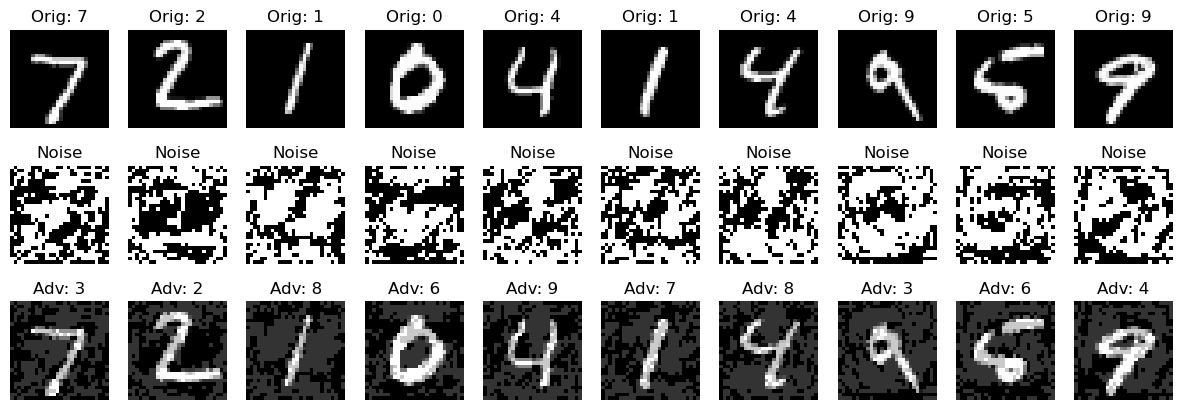

In [10]:
# Create a 3x10 grid of subplots to display images
# Loop through each sample to display the original image, noise, and adversarial image

fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i in range(10):
    # Original image
    axes[0, i].imshow(x_sample[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Orig: {true_labels[i]}")

    # Noise
    axes[1, i].imshow(noise[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Noise")

    # Adversarial image
    axes[2, i].imshow(x_adversarial[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title(f"Adv: {predictions[i]}")

plt.show()


## Step 11: Identifying Incorrect Predictions

In [11]:

# Find the indices of incorrectly classified samples after the FGSM attack
# Print the true and predicted labels for incorrectly classified samples

incorrect_indices = np.where(predictions != true_labels)[0]  # Get indices of misclassified samples
print("Incorrectly classified samples after FGSM attack:")  # Print message for misclassified samples

# Loop through each misclassified sample and print its true and predicted labels
for idx in incorrect_indices:
    print(f"True Label: {true_labels[idx]}, Predicted: {predictions[idx]}")  # Display true vs predicted labels


Incorrectly classified samples after FGSM attack:
True Label: 7, Predicted: 3
True Label: 1, Predicted: 8
True Label: 0, Predicted: 6
True Label: 4, Predicted: 9
True Label: 1, Predicted: 7
True Label: 4, Predicted: 8
True Label: 9, Predicted: 3
True Label: 5, Predicted: 6
True Label: 9, Predicted: 4


Based on the above code, perform the following:

**Adversarial Example Generation**
1. Use the create_adversarial_examples function to generate adversarial examples
for the given dataset (x_test, y_test). You will need to experiment with various values of epsilon (e.g., 0.1, 0.2, 0.3, 0.5, 1.0).

2. For each epsilon value, generate adversarial examples for a subset of x_test (you can choose 10 samples).

3. For each epsilon, store the adversarial examples and perturbations (noise).

**Model Evaluatation**
1. Evaluate the model on the generated adversarial examples for each epsilon value.

2. For each evaluation, compute the loss and accuracy.

3. Print the accuracy of the model on adversarial examples for each epsilon value.

4. Record how the accuracy decreases as epsilon increases (i.e., the strength of the perturbation).

**Visualization**:

For each epsilon value, plot the following:
1. The original images from the selected test samples.

2. The perturbation (noise) applied to each image to generate the adversarial examples.

3. The adversarial examples themselves.

Label the images accordingly (e.g., Original, Noise, and Adversarial).


# Important: Put the following graph in your Lab-Logbook
**Graphing the Results:**


1. Plot a graph showing the model's accuracy for each epsilon value. The x-axis should represent the epsilon values, and the y-axis should represent the accuracy of the model on the adversarial examples.

2. Discuss how the accuracy changes as the strength of the adversarial perturbation increases. What does this tell you about the model's robustness to adversarial attacks?

In [12]:
epsilons = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
accuracies = []

for eps in epsilons:
    x_adv, _ = create_adversarial_examples(model, x_sample, y_sample, epsilon=eps)
    _, acc = model.evaluate(x_adv, y_sample, verbose=0)
    accuracies.append(acc)
    print(f"Epsilon: {eps}, Accuracy: {acc:.4f}")


Epsilon: 0.0, Accuracy: 1.0000
Epsilon: 0.05, Accuracy: 0.7000
Epsilon: 0.1, Accuracy: 0.2000
Epsilon: 0.15, Accuracy: 0.1000
Epsilon: 0.2, Accuracy: 0.1000
Epsilon: 0.3, Accuracy: 0.0000
Epsilon: 0.5, Accuracy: 0.0000


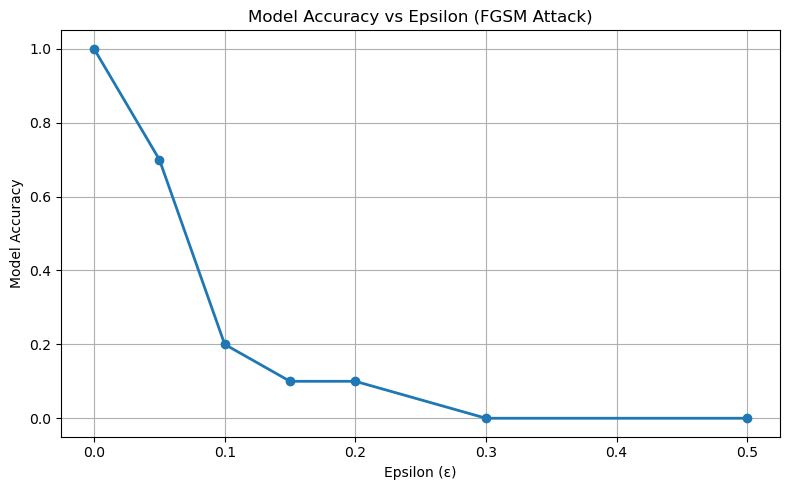

In [13]:
# Plot accuracy vs epsilon
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accuracies, marker='o', linewidth=2)
plt.xlabel("Epsilon (ε)")
plt.ylabel("Model Accuracy")
plt.title("Model Accuracy vs Epsilon (FGSM Attack)")
plt.grid(True)
plt.tight_layout()
plt.show()

In the next assignment, you will perform training data poisoning. Remember, x_train and y_train contain the training data. Your task is to poison the training data in a way that impacts the model's performance.

You will alter the labels in y_train by assigning incorrect labels to affect the model's accuracy. For example, you can set all values in y_train to a single label, chosen from 1 to 10. Alternatively, you can flip labels, such as setting label 2 to 1, and label 3 to 2, to degrade the model’s performance.

Feel free to perform any label manipulation of your choice in the training data, and observe the impact on the model’s accuracy.

# Important: In your lab logbook, provide the following:

The model accuracy before data poisoning.
The model accuracy after data poisoning.

In [15]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = keras.datasets.mnist.load_data()
x_train_scaled = x_train_orig.reshape(-1, 28*28) / 255.0
x_test_scaled = x_test_orig.reshape(-1, 28*28) / 255.0


y_train_onehot_clean = keras.utils.to_categorical(y_train_orig, 10)
y_test_onehot = keras.utils.to_categorical(y_test_orig, 10)

def build_mlp_model():
    model = keras.Sequential([
        keras.Input(shape=(784,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


clean_model = build_mlp_model()
clean_model.fit(x_train_scaled, y_train_onehot_clean, epochs=5, batch_size=128, verbose=0)
_, clean_accuracy = clean_model.evaluate(x_test_scaled, y_test_onehot, verbose=0)

y_train_all_class1 = np.ones_like(y_train_orig)
y_train_onehot_poisoned = keras.utils.to_categorical(y_train_all_class1, 10)


poisoned_model = build_mlp_model()
poisoned_model.fit(x_train_scaled, y_train_onehot_poisoned, epochs=5, batch_size=128, verbose=0)
_, poisoned_accuracy = poisoned_model.evaluate(x_test_scaled, y_test_onehot, verbose=0)

print(f"Accuracy before data poisoning: {clean_accuracy:.4f}")
print(f"Accuracy after data poisoning: {poisoned_accuracy:.4f}")

Accuracy before data poisoning: 0.9764
Accuracy after data poisoning: 0.1135


**Optional Part**

In this task, similar to the FGSM attack, you will implement a PGD (Projected Gradient Descent) attack on the AI model. The PGD attack is an iterative adversarial attack that refines the adversarial perturbation step-by-step to create stronger adversarial examples.

You can use the following libraries to implement the PGD attack. Make sure to experiment with different values of the attack parameters (e.g., number of iterations, step size, and epsilon) to observe how the attack affects the model’s performance.



https://github.com/Trusted-AI/adversarial-robustness-toolbox